
# Time Series Analysis in Medicine and Biology  
## Practical Course 2026 – University of Tübingen  

---

# Case Study: UK Respiratory Deaths (1974–1979)

We analyze BOTH male and female mortality series and construct a
structural generative model:

x_t = Baseline + Trend_t + Seasonal_t + Anomaly_t + Noise_t

Workflow:

1. Load data (external source)
2. Decompose (additive)
3. Estimate structural components
4. Detect anomalies
5. Simulate realistic synthetic series


## 1. Imports

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose


## 2. Load Data from External Repository

In [2]:

fdeaths_url = "https://vincentarelbundock.github.io/Rdatasets/csv/datasets/fdeaths.csv"
mdeaths_url = "https://vincentarelbundock.github.io/Rdatasets/csv/datasets/mdeaths.csv"

fdeaths = pd.read_csv(fdeaths_url, index_col=0)
mdeaths = pd.read_csv(mdeaths_url, index_col=0)


female = fdeaths["value"]
male = mdeaths["value"]

dates = pd.date_range(start="1974-01-01", periods=len(male), freq="M")
male.index = dates
female.index = dates

male.head()


1974-01-31    2134
1974-02-28    1863
1974-03-31    1877
1974-04-30    1877
1974-05-31    1492
Freq: M, Name: value, dtype: int64

## 3. Real Data

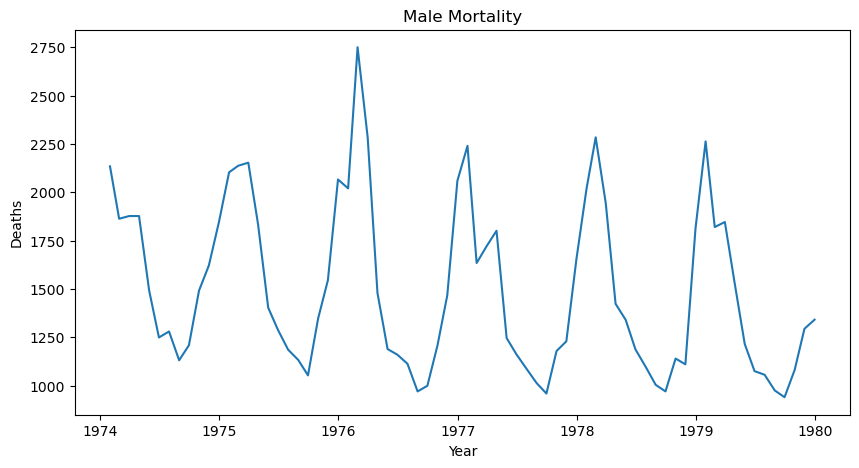

In [3]:

plt.figure(figsize=(10,5))
plt.plot(male)
plt.title("Male Mortality")
plt.xlabel("Year")
plt.ylabel("Deaths")
plt.show()


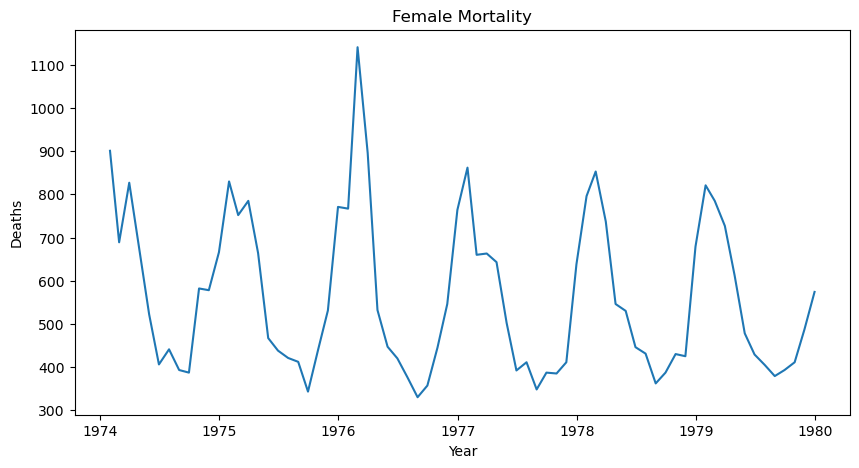

In [4]:

plt.figure(figsize=(10,5))
plt.plot(female)
plt.title("Female Mortality")
plt.xlabel("Year")
plt.ylabel("Deaths")
plt.show()


## 4. Additive Decomposition (Male)

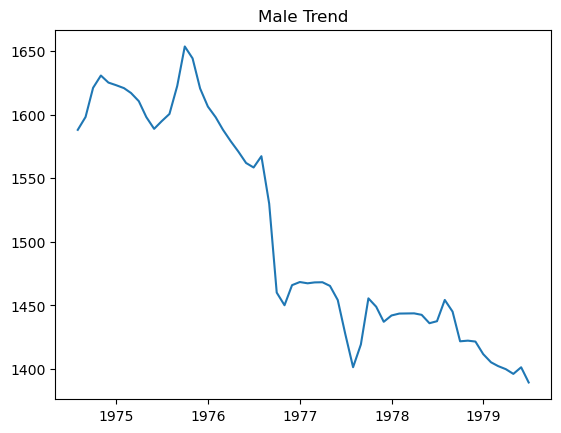

In [5]:

decomp_male = seasonal_decompose(male, model="additive", period=12)
plt.figure()
plt.plot(decomp_male.trend)
plt.title("Male Trend")
plt.show()


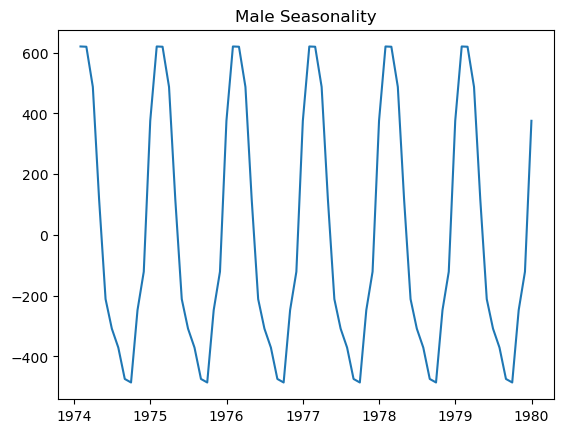

In [6]:

plt.figure()
plt.plot(decomp_male.seasonal)
plt.title("Male Seasonality")
plt.show()


## 5. Additive Decomposition (Female)

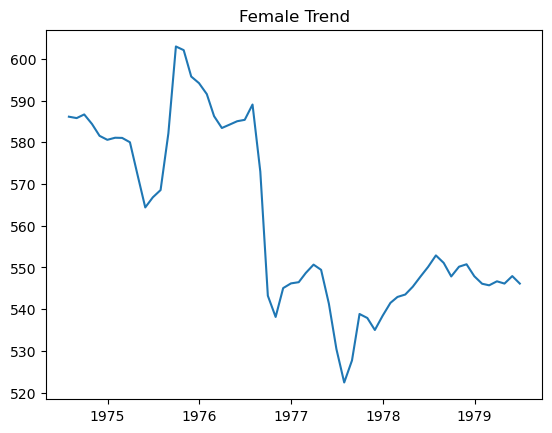

In [7]:

decomp_female = seasonal_decompose(female, model="additive", period=12)
plt.figure()
plt.plot(decomp_female.trend)
plt.title("Female Trend")
plt.show()


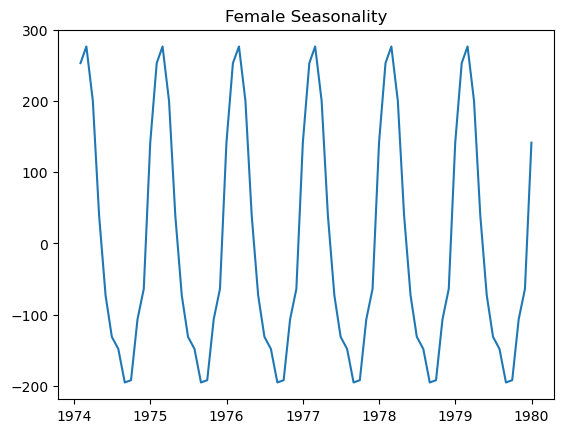

In [8]:

plt.figure()
plt.plot(decomp_female.seasonal)
plt.title("Female Seasonality")
plt.show()


## 6. Structural Estimation Function

In [9]:

def estimate_structure(series):
    t = np.arange(len(series))

    
    # Baseline + Trend via regression
    coeffs = np.polyfit(t, series, 1)
    baseline_trend = coeffs[0]*t + coeffs[1]
    
    # Seasonal pattern
    monthly_mean = series.groupby(series.index.month).mean()
    seasonal_pattern = monthly_mean - monthly_mean.mean()
    season = np.tile(seasonal_pattern.values, len(series)//12)
    
    # Structural residual
    residual = series - (baseline_trend + season)
    noise_std = residual.std()
    
    return baseline_trend, season, residual, noise_std


## 7. Estimate Structural Components

In [10]:

baseline_trend_m, season_m, residual_m, noise_std_m = estimate_structure(male)
baseline_trend_f, season_f, residual_f, noise_std_f = estimate_structure(female)



## 8. Anomaly Detection

We define anomalies as:

|z_t| > 2


In [11]:

z_m = residual_m / noise_std_m
anomaly_idx_m = np.where(np.abs(z_m) > 2)[0]

z_f = residual_f / noise_std_f
anomaly_idx_f = np.where(np.abs(z_f) > 2)[0]


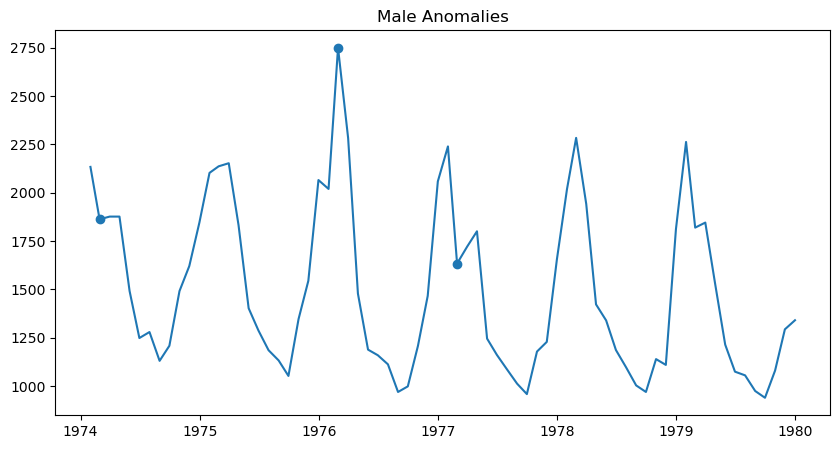

In [12]:

plt.figure(figsize=(10,5))
plt.plot(male)
plt.scatter(male.index[anomaly_idx_m], male.iloc[anomaly_idx_m])
plt.title("Male Anomalies")
plt.show()


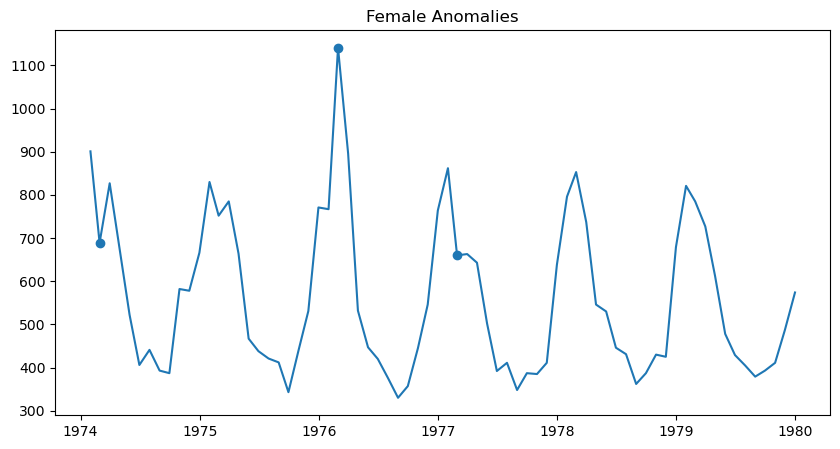

In [13]:

plt.figure(figsize=(10,5))
plt.plot(female)
plt.scatter(female.index[anomaly_idx_f], female.iloc[anomaly_idx_f])
plt.title("Female Anomalies")
plt.show()


## 9. Structural Simulation

In [19]:

def simulate(series, baseline_trend, season, residual, noise_std):
    z = residual / noise_std
    anomaly_idx = np.where(np.abs(z) > 2)[0]
    
    anomaly_component = np.zeros(len(series))
    anomaly_component[anomaly_idx] = residual.iloc[anomaly_idx]
    
    np.random.seed(42)
    noise = np.random.normal(0, noise_std, len(series))
    
    simulated = baseline_trend  + season + anomaly_component + noise
    return simulated


In [20]:

sim_male = simulate(male, baseline_trend_m, season_m, residual_m, noise_std_m)
sim_female = simulate(female, baseline_trend_f, season_f, residual_f, noise_std_f)


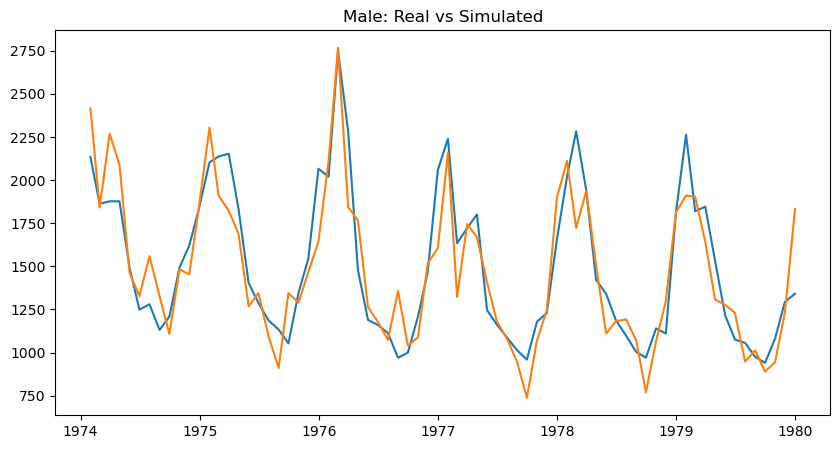

In [21]:

plt.figure(figsize=(10,5))
plt.plot(male)
plt.plot(male.index, sim_male)
plt.title("Male: Real vs Simulated")
plt.show()


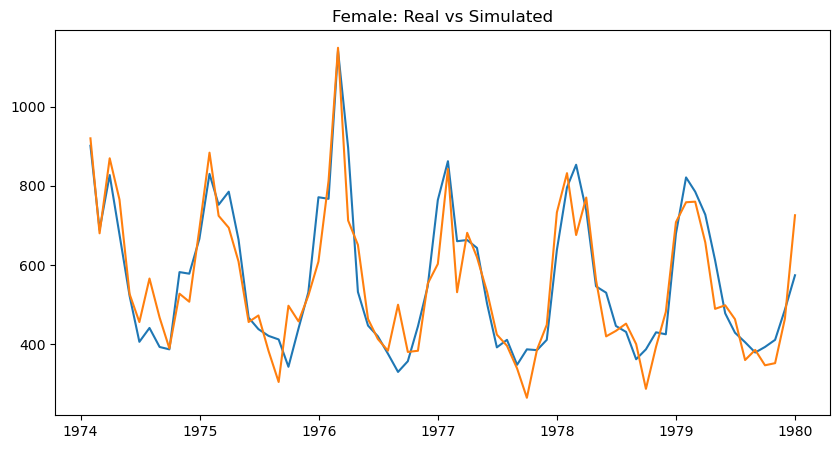

In [22]:

plt.figure(figsize=(10,5))
plt.plot(female)
plt.plot(female.index, sim_female)
plt.title("Female: Real vs Simulated")
plt.show()
